# Exploratory Data Analysis on FedEx Delivery Operations
This notebook performs a complete EDA. It includes data cleaning, univariate/bivariate analyses, geographic & operational insights, and business recommendations.

## Setup

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display options
pd.set_option('display.max_columns', None)


## Load the dataset & first look

In [3]:
# Load the CSV
df = pd.read_csv("/Users/shivalimuthukumar/Desktop/fedex_deliveries.csv", parse_dates=["Pickup_Date","Delivery_Date"])

display(df.head())

# Basic structure
print("Rows, Columns:", df.shape)
display(df.dtypes)


,ShipmentID,Origin,Destination,Pickup_Date,Delivery_Date,Delivery_Status,Distance_KM,Shipment_Mode,Weight_KG,Cost_USD,Customer_Segment,Delay_Reason
0,SHP100000,Seattle,New York,2025-03-10,2025-03-18 04:48:00,In Transit,3781.5,Ground,34.05,10593.11,Retail,Operational
1,SHP100001,Detroit,Los Angeles,2025-08-30,2025-09-04 09:36:00,Delivered,2838.7,Ground,18.84,5415.39,Business,NaN
2,SHP100002,Phoenix,San Diego,2025-01-07,2025-01-10 02:24:00,Delivered,1216.1,Freight,23.82,3458.32,Retail,NaN
3,SHP100003,Miami,San Francisco,2024-09-29,2024-10-04 21:36:00,Delivered,3003.8,Ground,31.86,7378.63,Business,NaN
4,SHP100004,Seattle,Miami,2025-07-29,2025-07-31 16:48:00,Delivered,1204.5,Ground,21.86,2733.05,Retail,NaN


Rows, Columns: (5000, 12)


ShipmentID                  object
Origin                      object
Destination                 object
Pickup_Date         datetime64[ns]
Delivery_Date       datetime64[ns]
Delivery_Status             object
Distance_KM                float64
Shipment_Mode               object
Weight_KG                  float64
Cost_USD                   float64
Customer_Segment            object
Delay_Reason                object
dtype: object

## Part A: Data Understanding & Cleaning

### 1) Identify missing values & plan to handle them

In [5]:
# Count missing values per column
missing_counts = df.isna().sum().sort_values(ascending=False)
display(missing_counts.to_frame('Missing_Count'))

# Strategy:
# - Numerical (Weight_KG, Cost_USD, Distance_KM): fill with median.
# - Categorical (Shipment_Mode, Delay_Reason): fill with mode.
# - Dates are already present by generation; if missing, dropping those records.


,Missing_Count
Delay_Reason,2950
Weight_KG,97
Cost_USD,88
Distance_KM,50
Shipment_Mode,26
ShipmentID,0
Origin,0
Destination,0
Pickup_Date,0
Delivery_Date,0


### 2) Handle missing values (imputation)

In [6]:
# Impute numeric with median
for col in ["Weight_KG","Cost_USD","Distance_KM"]:
    med = df[col].median()
    df[col] = df[col].fillna(med)

# Impute categorical with mode
for col in ["Shipment_Mode","Delay_Reason"]:
    mode_val = df[col].mode(dropna=True)[0]
    df[col] = df[col].fillna(mode_val)

# Verify no remaining missing values
display(df.isna().sum())


ShipmentID          0
Origin              0
Destination         0
Pickup_Date         0
Delivery_Date       0
Delivery_Status     0
Distance_KM         0
Shipment_Mode       0
Weight_KG           0
Cost_USD            0
Customer_Segment    0
Delay_Reason        0
dtype: int64

### 3) Convert dates & create `Delivery_Time_Days`

In [7]:
# Dates already parsed via read_csv
df['Pickup_Date'] = pd.to_datetime(df['Pickup_Date'])
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'])

# Delivery time in days
df['Delivery_Time_Days'] = (df['Delivery_Date'] - df['Pickup_Date']).dt.total_seconds() / (24*3600)
df['Delivery_Time_Days'] = df['Delivery_Time_Days'].round(1)

display(df[['Pickup_Date','Delivery_Date','Delivery_Time_Days']].head())


,Pickup_Date,Delivery_Date,Delivery_Time_Days
0,2025-03-10,2025-03-18 04:48:00,8.2
1,2025-08-30,2025-09-04 09:36:00,5.4
2,2025-01-07,2025-01-10 02:24:00,3.1
3,2024-09-29,2024-10-04 21:36:00,5.9
4,2025-07-29,2025-07-31 16:48:00,2.7


## Part B: Univariate and Bivariate Analysis

### Distribution of `Delivery_Time_Days` & Average Delivery Time

Average delivery time (days): 4.72


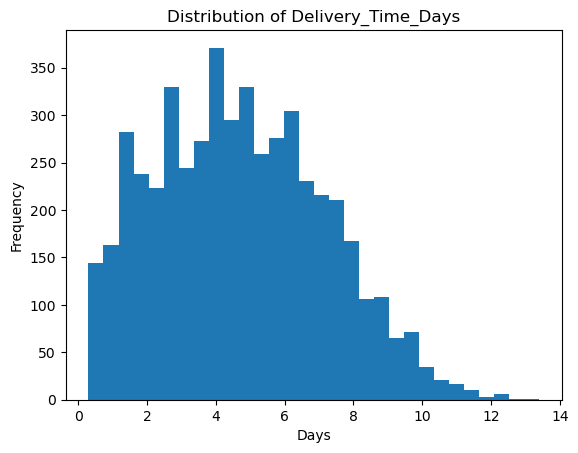

In [8]:
avg_time = df['Delivery_Time_Days'].mean()
print(f"Average delivery time (days): {avg_time:.2f}")

plt.figure()
plt.hist(df['Delivery_Time_Days'], bins=30)
plt.title('Distribution of Delivery_Time_Days')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()


### Shipment volume by `Shipment_Mode`

,Count
Shipment_Mode,
Ground,2544
Air,1701
Freight,755


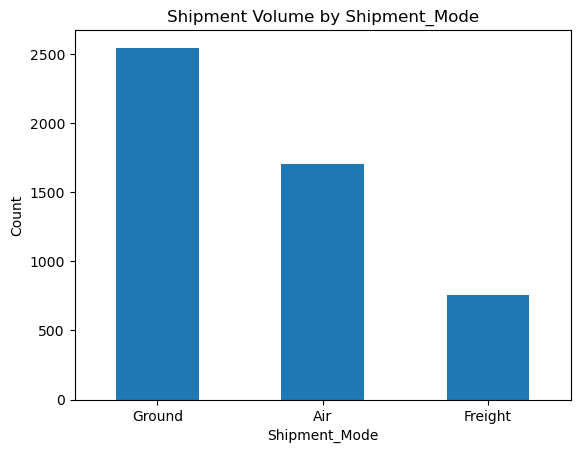

In [9]:
mode_counts = df['Shipment_Mode'].value_counts().sort_values(ascending=False)
display(mode_counts.to_frame('Count'))

plt.figure()
mode_counts.plot(kind='bar')
plt.title('Shipment Volume by Shipment_Mode')
plt.xlabel('Shipment_Mode')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


### Average shipping cost per `Customer_Segment`

,Avg_Cost_USD
Customer_Segment,
Retail,5570.10
Business,5165.63
Government,5001.36


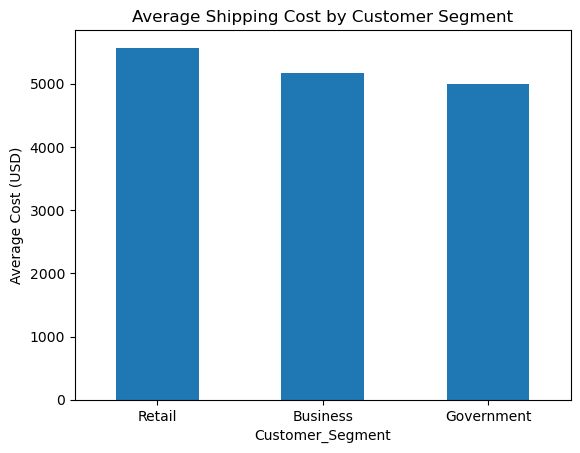

In [10]:
avg_cost_segment = df.groupby('Customer_Segment')['Cost_USD'].mean().sort_values(ascending=False)
display(avg_cost_segment.to_frame('Avg_Cost_USD').round(2))

plt.figure()
avg_cost_segment.plot(kind='bar')
plt.title('Average Shipping Cost by Customer Segment')
plt.xlabel('Customer_Segment')
plt.ylabel('Average Cost (USD)')
plt.xticks(rotation=0)
plt.show()


### Delivery status counts

,Count
Delivery_Status,
Delivered,3753
In Transit,688
Delayed,559


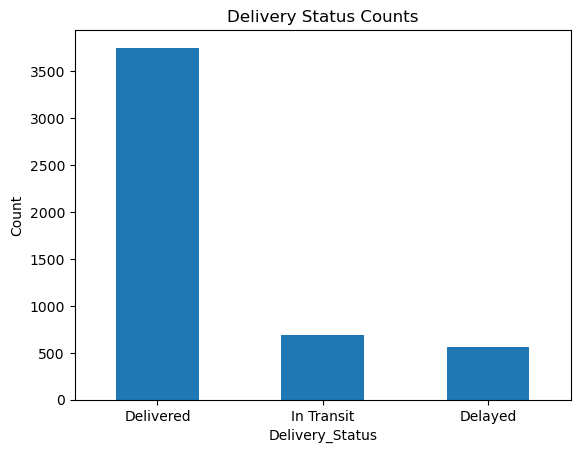

In [11]:
status_counts = df['Delivery_Status'].value_counts()
display(status_counts.to_frame('Count'))

plt.figure()
status_counts.plot(kind='bar')
plt.title('Delivery Status Counts')
plt.xlabel('Delivery_Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


### Relationship between `Weight_KG` and `Cost_USD`

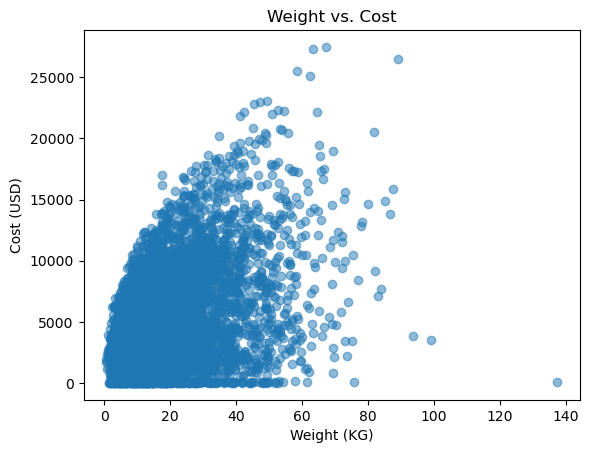

In [12]:
plt.figure()
plt.scatter(df['Weight_KG'], df['Cost_USD'], alpha=0.5)
plt.title('Weight vs. Cost')
plt.xlabel('Weight (KG)')
plt.ylabel('Cost (USD)')
plt.show()


## Part C: Geographic and Operational Insights

### Top 5 city pairs (Origin–Destination) by shipment frequency

In [13]:
pair_counts = (
    df.groupby(['Origin','Destination'])
      .size()
      .sort_values(ascending=False)
      .head(5)
      .rename('Count')
)
display(pair_counts)


Origin         Destination
San Francisco  Houston        28
Seattle        Charlotte      26
Boston         Boston         26
Detroit        Miami          26
Boston         Seattle        25
Name: Count, dtype: int64

### Delivery delays by `Shipment_Mode` (stacked bar of status within mode)

Delivery_Status,Delayed,Delivered,In Transit
Shipment_Mode,,,
Air,172,1317,212
Freight,89,534,132
Ground,298,1902,344


<Figure size 640x480 with 0 Axes>

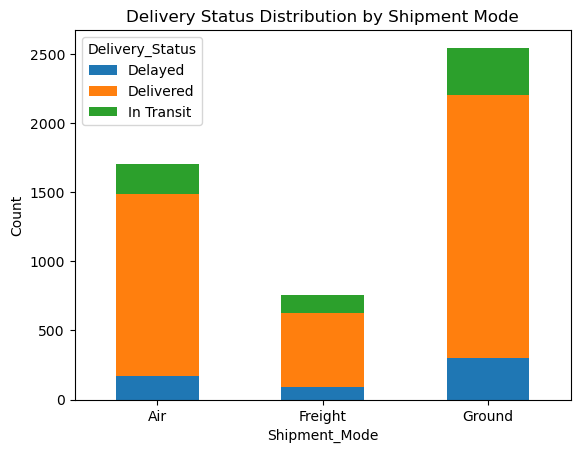

In [14]:
ct = pd.crosstab(df['Shipment_Mode'], df['Delivery_Status'])
display(ct)

plt.figure()
ct.plot(kind='bar', stacked=True)
plt.title('Delivery Status Distribution by Shipment Mode')
plt.xlabel('Shipment_Mode')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Delivery_Status')
plt.show()


### Correlation heatmap of numeric features

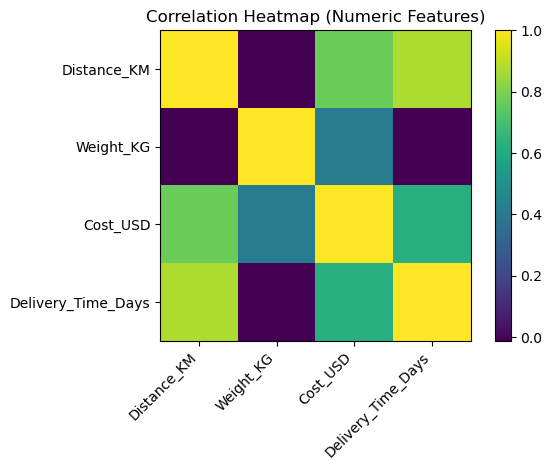

,Distance_KM,Weight_KG,Cost_USD,Delivery_Time_Days
Distance_KM,1.000,-0.012,0.772,0.875
Weight_KG,-0.012,1.000,0.402,-0.009
Cost_USD,0.772,0.402,1.000,0.623
Delivery_Time_Days,0.875,-0.009,0.623,1.000


In [15]:
numeric_cols = ['Distance_KM','Weight_KG','Cost_USD','Delivery_Time_Days']
corr = df[numeric_cols].corr()

import numpy as np
plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.title('Correlation Heatmap (Numeric Features)')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.colorbar()
plt.tight_layout()
plt.show()

display(corr.round(3))


### Most common `Delay_Reason` and its impact on `Delivery_Time_Days`

,Count
Delay_Reason,
Operational,4002
Weather,751
Customs,247


,Avg_Delivery_Time_Days
Delay_Reason,
Customs,6.71
Weather,5.88
Operational,4.37


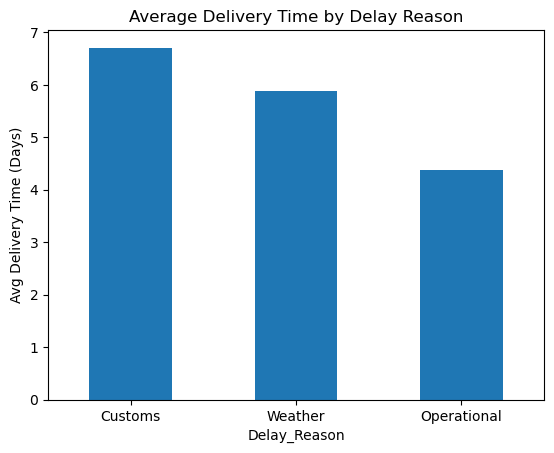

In [16]:
delay_counts = df['Delay_Reason'].value_counts()
display(delay_counts.to_frame('Count'))

impact = df.groupby('Delay_Reason')['Delivery_Time_Days'].mean().sort_values(ascending=False)
display(impact.to_frame('Avg_Delivery_Time_Days').round(2))

plt.figure()
impact.plot(kind='bar')
plt.title('Average Delivery Time by Delay Reason')
plt.xlabel('Delay_Reason')
plt.ylabel('Avg Delivery Time (Days)')
plt.xticks(rotation=0)
plt.show()


### Compare average delivery times between `Shipment_Mode`s

,Avg_Delivery_Time_Days
Shipment_Mode,
Air,4.08
Ground,4.80
Freight,5.87


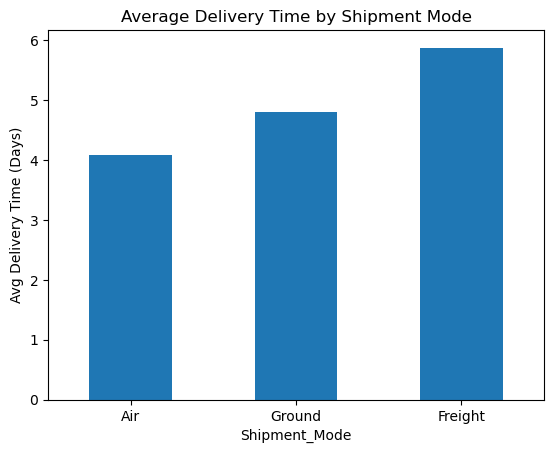

In [17]:
avg_time_by_mode = df.groupby('Shipment_Mode')['Delivery_Time_Days'].mean().sort_values()
display(avg_time_by_mode.to_frame('Avg_Delivery_Time_Days').round(2))

plt.figure()
avg_time_by_mode.plot(kind='bar')
plt.title('Average Delivery Time by Shipment Mode')
plt.xlabel('Shipment_Mode')
plt.ylabel('Avg Delivery Time (Days)')
plt.xticks(rotation=0)
plt.show()


## Part D: Business Recommendations

Based on the above analyses:

1. **Operational Inefficiencies:** If certain delay reasons (e.g., *Customs* or *Operational*) correlate with longer delivery times, prioritize root-cause fixes (pre-clearance for customs, capacity planning for operations).
2. **Shipment Mode Allocation:** For short distances (e.g., < 500 KM), **Ground** can offer comparable delivery times at lower cost versus **Air**; consider routing rules accordingly.
3. **Cost Reduction Strategies:** For high-cost segments (e.g., heavy + long-distance via Air), implement **mode downgrade** eligibility with SLAs, and negotiate **business-segment contracts**.
4. **Customer Satisfaction:** Trigger **proactive notifications** for Weather/Customs delays with revised ETAs; offer coupons or fee waivers for severe delays.


## Save the cleaned dataset

In [18]:
clean_path = '/Users/shivalimuthukumar/Desktop/fedex_deliveries_cleaned.csv'
df.to_csv(clean_path, index=False)
print('Saved cleaned file ->', clean_path)


Saved cleaned file -> /Users/shivalimuthukumar/Desktop/fedex_deliveries_cleaned.csv
